## Project Code | Edge Detection using Sobel Filter | Group 6

The custom overlay consists of 2 DMAs and 2 custom filter IPs for Sobel x and y.

* The axi_dma_y is connected to sobel_y while the axi_dma_x is connected to sobel_x.
* both the DMAs have read-write channels enabled to receive data from DDR memory and send to PL, then write it back to DDR memory.


## 1. Libraries used and Image capture

For the project, we used time, numpy, matplotlib, scipy, PIL, cv2 and the pynq libraries for the project

number of images to process from the webcam: 3
,False
,False
,3


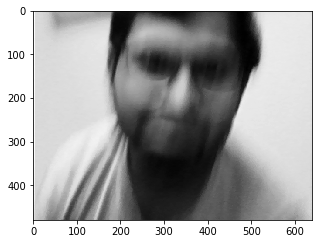

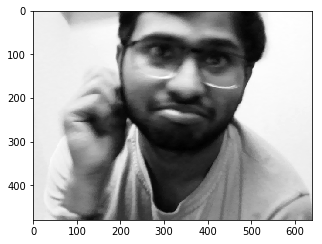

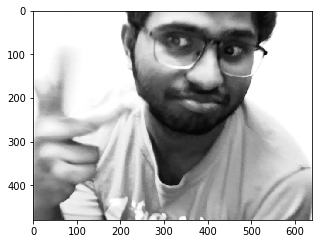

In [1]:
from pynq import Overlay            #libraries included

from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
from scipy  import ndimage
from PIL import Image, ImageFilter
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pynq.lib.dma
from pynq import allocate
import numpy as np
import cv2

# Capturing images from the webcam, user will input no of images to process 

#the following loops capture n(user input) images from the webcam and store them in a list
image_list=[]
n=int(input("number of images to process from the webcam: "))
i=0
while i<n:
    ret=False
    while ret==False:
        cap = cv2.VideoCapture(0) 
        ret, cv2_im = cap.read()
        if ret==True:
            #print(cv2_im.shape)
            cv2_im=np.dot(cv2_im[...,:3], [0.2989, 0.5870, 0.1140])
            #print(cv2_im.shape)
            image_list.append(cv2_im)
            plt.figure(figsize=(5,5))
            plt.imshow(cv2_im, cmap='gray')
        else:
            print(ret)
    i+=1

print(len(image_list))



Here we instantiate our custom overlay

In [2]:
overlay = Overlay("./bitstream/sob.bit")

## 2. Create DMA instances

Using the DMA labels as in the bit file, we create two DMA objects, 1 for sobel_x, the other for sobel_y.

In [3]:
dma_x = overlay.axi_dma_x
dma_y = overlay.axi_dma_y

## 3. Buffer Initialization
The first step is to allocate the buffer. pynq.allocate will be used to allocate the buffer, and NumPy will be used to specify the datatype of the buffer. 

In [4]:
data_size = 307200 #the size of a 640x480 image
input_buffer = allocate(shape=(data_size,), dtype=np.uint32)
output_buffer = allocate(shape=(data_size,), dtype=np.uint32)
output_buffer_y = allocate(shape=(data_size,), dtype=np.uint32)


## 4. Custom Function Definition
Here we create a custom python function to take input image from webcam (which is a ndarray) and send it to the DMAs for processing and receive them back in memory for further processing (gradient calculation and display on notebook)

In [5]:
def sobel_exec(img,k):
    
    OG_array=img                    #storing img in new variable named OG_array
    plt.figure(figsize=(5, 5))
    _=plt.imshow(OG_array, cmap='gray')
    _=plt.title('input image: '+str(k))
    im = Image.fromarray(OG_array)      #creating Pillow image object from ndarray

    #reshaping 2d array to 1d for input_buffer
    reshaped_array=np.reshape(OG_array,-1)
    reshaped_array=reshaped_array.astype(np.uint32)
    
    #feeding the reshaped_array into input_buffer
    for i in range(data_size):
        input_buffer[i] = reshaped_array[i]
    
    
    
    print("Time stats for image: "+str(k))
    start_hw = time.time()
    
    #sending the reshaped array to DMA using input buffer for HW processing
    dma_x.sendchannel.transfer(input_buffer)
    dma_y.sendchannel.transfer(input_buffer)
    
    #receiving the processed data from DMA using output buffers
    dma_x.recvchannel.transfer(output_buffer)
    dma_y.recvchannel.transfer(output_buffer_y)

    end_hw =time.time()
    time_hw=end_hw-start_hw
    print("time to process sobel x,y in hardware: "+str(round(time_hw,5)))
    
    #creating ndarrays for storing output buffer data
    output_array=np.array(output_buffer)
    output_array_y=np.array(output_buffer_y)

 
    start_hw_sw=time.time()

    #reshaping back to image dimensions for display/plot
    reshaped_output_array=np.reshape(output_array,(480,640))
    reshaped_output_array_y=np.reshape(output_array_y,(480,640))
    
    #gradient calculation in SW
    gradient = np.sqrt(reshaped_output_array_y**2 + reshaped_output_array**2)
    gradient=gradient.astype(np.uint8) 
    
    reshaped_gradient=np.reshape(gradient, (480, 640))
    
    #plotting HW outputs in jupyter notebook
    plt.figure(figsize=(20, 20))
    
    plt.subplot(1,3,1)
    _=plt.imshow(reshaped_output_array_y, cmap='gray')
    _=plt.title('hardware sobel y image')
    plt.figtext(0.425, 0.625, "image " + str(k) + " outputs", fontsize=20, va='top')
    
    plt.subplot(1,3,2)
    _=plt.imshow(reshaped_output_array, cmap='gray')
    _=plt.title('hardware sobel x image')
    
    plt.subplot(1,3,3)
    _=plt.imshow(reshaped_gradient, cmap='gray')
    _=plt.title('hardware gradient Image')
    
   
    end_hw_sw = time.time()

    time_hw_sw=end_hw_sw-start_hw_sw
    print("Total Time taken in hardware: "+ str(round((time_hw+time_hw_sw),3)))
    
    
    # pure SW implementation of sobel filter using SciPy library
    start_sw=time.time()
    sobel_h = ndimage.sobel(im, 0)
    sobel_v = ndimage.sobel(im, 1)

    end_sw=time.time()

    time_sw=end_sw-start_sw
    print("Time in software for sobel x,y: "+str(round(time_sw,5)))

    start_sw_2=time.time()
    
    #plotting SW outputs in jupyter notebook
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    _=plt.imshow(sobel_h, cmap='gray')
    _=plt.title('software sobel y image')

    plt.subplot(1,3,2)
    _=plt.imshow(sobel_v, cmap='gray')
    _=plt.title('software sobel x image')
   
    magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
    #magnitude *= 255.0 / np.max(magnitude)  # normalization
    magnitude=magnitude.astype(np.uint8) 

    plt.subplot(1,3,3)
    _=plt.imshow(magnitude, cmap='gray')
    _=plt.title('software gradient image')
    
    
    end_sw_2=time.time()
    time_sw_2=end_sw_2-start_sw_2
    print("Total time in software :", str(round((time_sw+time_sw_2),3)))

    factor=time_sw/time_hw

    print("HW speedup factor: "+ str(round(factor)))
    print()
    
    
    grad_pad=np.pad(reshaped_gradient, [(0, 240), (0, 640)], mode='constant', constant_values=0)
    final_x_pad=np.pad(reshaped_output_array, [(0, 240), (0, 640)], mode='constant', constant_values=0)
    final_y_pad=np.pad(reshaped_output_array_y, [(0, 240), (0, 640)], mode='constant', constant_values=0)
    
#     grad_pad=reshaped_gradient
#     final_x_pad=reshaped_output_array
#     final_y_pad=reshaped_output_array_y
    
          
    return final_x_pad, final_y_pad, grad_pad;




## 5. Function Call
Here we call the function to process each image taken from the webcam

Time stats for image: 0
,time to process sobel x,y in hardware: 0.0008
,Total Time taken in hardware: 1.527
,Time in software for sobel x,y: 0.17207
,Total time in software : 1.396
,HW speedup factor: 214
,
,Time stats for image: 1
,time to process sobel x,y in hardware: 0.00081
,Total Time taken in hardware: 1.266
,Time in software for sobel x,y: 0.17809
,Total time in software : 1.408
,HW speedup factor: 221
,
,Time stats for image: 2
,time to process sobel x,y in hardware: 0.00084
,Total Time taken in hardware: 1.266
,Time in software for sobel x,y: 0.17863
,Total time in software : 1.397
,HW speedup factor: 214
,


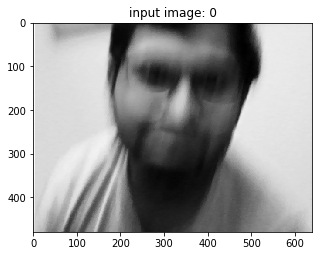

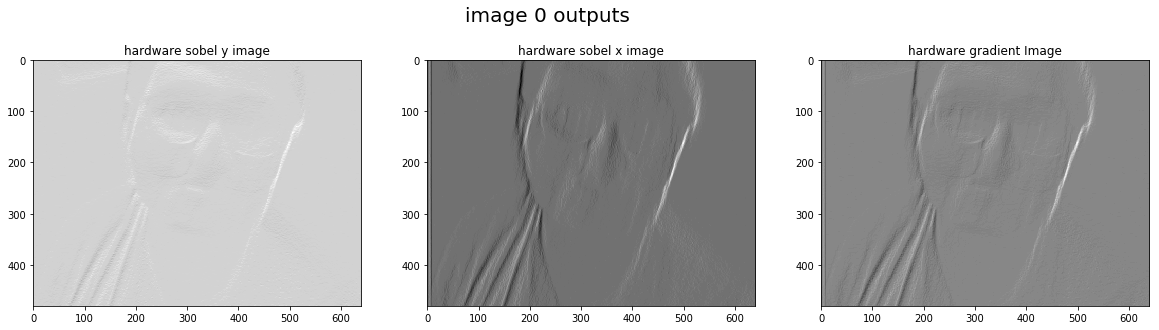

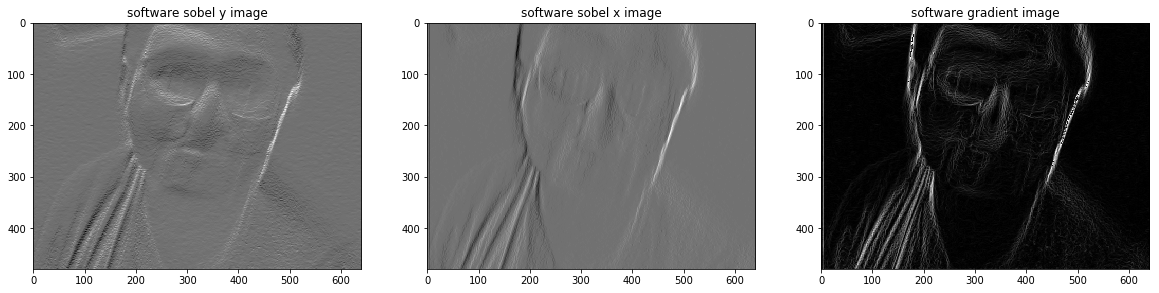

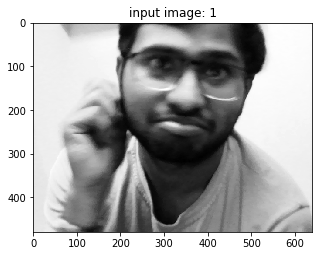

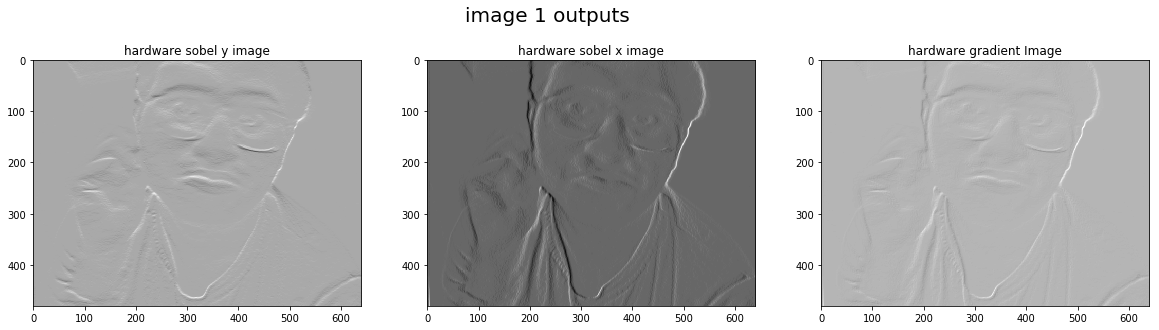

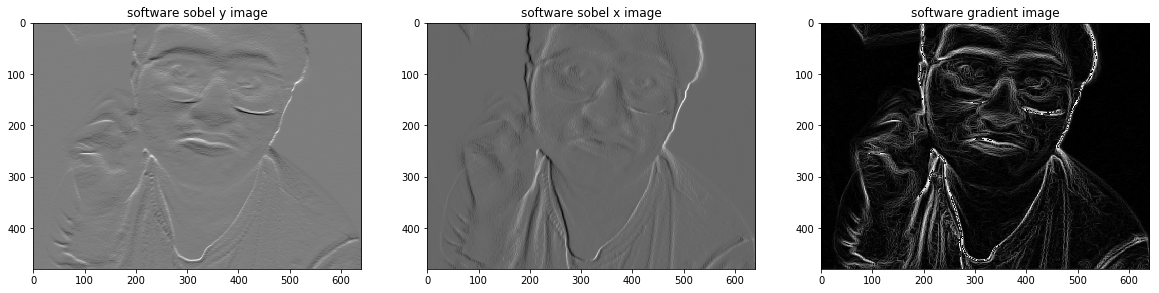

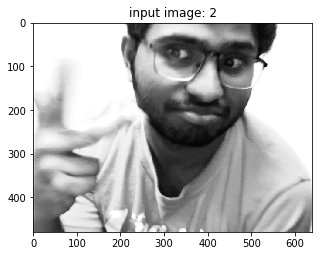

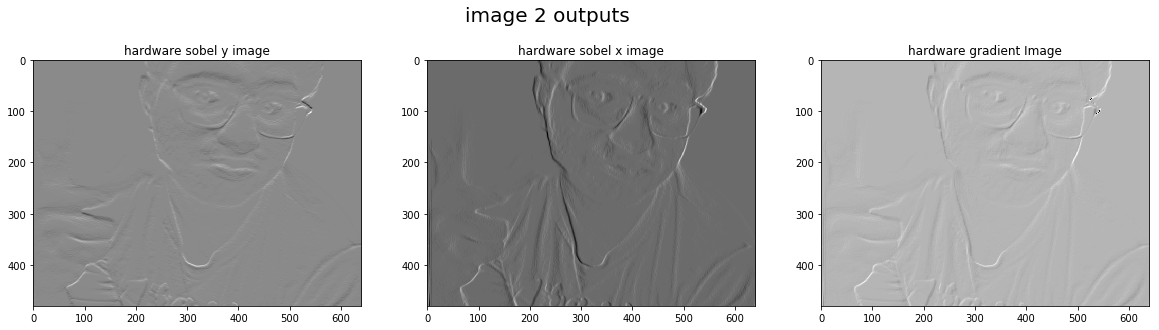

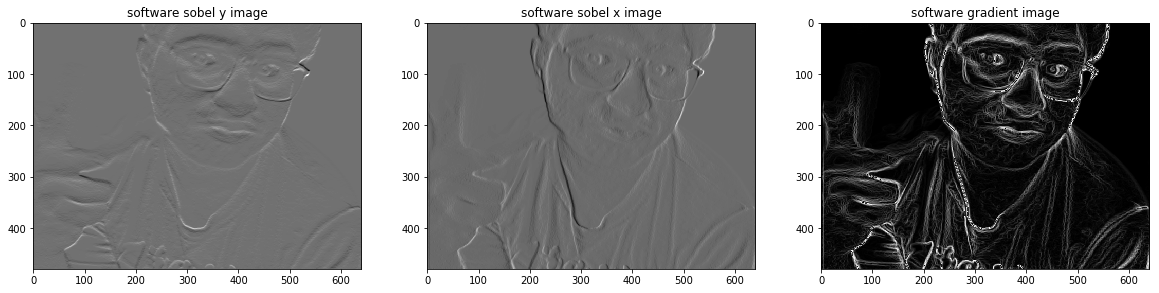

In [6]:
grad_pad_out = []
for i in range(len(image_list)):
        grad_pad_out.append(sobel_exec(image_list[i],i))


## 6. 2nd Overlay for Monitor Display
Now we are ready to show our outputs on a display monitor through HDMI
We call a default overlay "base.bit" which has hdmi in and out capabilities and initialize hdmi_out parameters like resolution, fps and frame datasize (8 for grayscale, 24 for RGB)


In [7]:
#loading new overlay for hdmi output
base = BaseOverlay("base.bit")
hdmi_out = base.video.hdmi_out

#setting display resolution
frame_in_w=1280
frame_in_h=720

# frame_in_w=640
# frame_in_h=480


Mode=VideoMode(frame_in_w,frame_in_h,8,fps=30)

#initializing hdmi with above parameters
hdmi_out.configure(Mode)

hdmi_out.start()

## 7. Display Loop
This code snippet allows us to cycle through sobel_x, sobel_y and gradient images for each input image and send to hdmi_out for display

In [ ]:

outframe=hdmi_out.newframe()


while True:
     for i in range(len(grad_pad_out)):
            count=0
            while count<3:
                if count%3==0:
                    outframe[:]=grad_pad_out[i][0]
                elif count%3==1:
                    outframe[:]=grad_pad_out[i][1]
                elif count%3==2:
                    outframe[:]=grad_pad_out[i][2]
                    
                time.sleep(3)    
                count+=1
                hdmi_out.writeframe(outframe)



## 8. Free all the memory buffers
Don't forget to free the memory buffers to avoid memory leaks!

In [ ]:
del input_buffer
del output_buffer
del output_buffer_y